In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from haversine import haversine
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import joblib
import folium
from folium.plugins import HeatMap
import requests

In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [5]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [6]:
data.drop('key', axis=1, inplace=True)
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [7]:
print("Missing values per column:")
print(data.isnull().sum())

Missing values per column:
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [8]:
NYC_LAT_MIN, NYC_LAT_MAX = 40.477399, 40.917577
NYC_LON_MIN, NYC_LON_MAX = -74.259090, -73.700272

data = data[
    (data['pickup_latitude'] >= NYC_LAT_MIN) & (data['pickup_latitude'] <= NYC_LAT_MAX) &
    (data['pickup_longitude'] >= NYC_LON_MIN) & (data['pickup_longitude'] <= NYC_LON_MAX) &
    (data['dropoff_latitude'] >= NYC_LAT_MIN) & (data['dropoff_latitude'] <= NYC_LAT_MAX) &
    (data['dropoff_longitude'] >= NYC_LON_MIN) & (data['dropoff_longitude'] <= NYC_LON_MAX)
]

print(f"Dataset size after cleaning: {data.shape}")


Dataset size after cleaning: (48873, 7)


In [9]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday
data['pickup_month'] = data['pickup_datetime'].dt.month


In [10]:
def calculate_haversine_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(pickup, dropoff)

data['haversine_distance_km'] = data.apply(calculate_haversine_distance, axis=1)
data = data[data['haversine_distance_km'] != 0]

data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_weekday,pickup_month,haversine_distance_km
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,0,6,1.030765
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,8.450145
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3,8,1.389527
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,5,4,2.799274
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1,3,1.999160


In [11]:
data['is_night'] = ((data['pickup_hour'] >= 20) & (data['pickup_hour'] <= 23)).astype(int)
data['is_late_night'] = ((data['pickup_hour'] > 23) | (data['pickup_hour'] <= 6)).astype(int)
data['is_weekend'] = (data['pickup_weekday'] >=5).astype(int)

In [12]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_weekday,pickup_month,haversine_distance_km,is_night,is_late_night,is_weekend
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,0,6,1.030765,0,0,0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,8.450145,0,0,0
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3,8,1.389527,0,1,0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,5,4,2.799274,0,1,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1,3,1.999160,0,0,0


In [13]:
#normalization
scaler = MinMaxScaler()

scaler.fit(data[['fare_amount', 'haversine_distance_km']]) 

data[['fare_amount', 'haversine_distance_km']] = scaler.transform(data[['fare_amount', 'haversine_distance_km']])
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_weekday,pickup_month,haversine_distance_km,is_night,is_late_night,is_weekend
0,0.055882,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,0,6,0.030454,0,0,0
1,0.128824,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,0.249674,0,0,0
2,0.062941,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3,8,0.041054,0,1,0
3,0.074706,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,5,4,0.082708,0,1,1
4,0.060588,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1,3,0.059067,0,0,0


In [14]:
# Latitude and longitude differences
data['lat_diff'] = data['dropoff_latitude'] - data['pickup_latitude']
data['lon_diff'] = data['dropoff_longitude'] - data['pickup_longitude']

In [15]:
data.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_weekday,pickup_month,haversine_distance_km,is_night,is_late_night,is_weekend,lat_diff,lon_diff
0,0.055882,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,0,6,0.030454,0,0,0,-0.009041,0.002701
1,0.128824,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,0.249674,0,0,0,0.070701,0.036780
2,0.062941,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3,8,0.041054,0,1,0,-0.010708,-0.008504
3,0.074706,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,5,4,0.082708,0,1,1,0.024949,-0.004437
4,0.060588,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1,3,0.059067,0,0,0,0.015754,0.011440


In [16]:
def get_route(start_lat, start_lon, end_lat, end_lon):
    if None in [start_lat, start_lon, end_lat, end_lon]:
        print("Error: Missing coordinates")
        return None, None  

    url = f"http://localhost:5000/route/v1/driving/{start_lon},{start_lat};{end_lon},{end_lat}?overview=false"
    
    try:
        response = requests.get(url)
        response.raise_for_status()  
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None, None  

    if response.status_code == 200:
        data = response.json()
        distance = data['routes'][0]['distance'] / 1000  
        duration = data['routes'][0]['duration'] / 60  
        return distance, duration  
    else:
        print(f"Error: Unable to fetch route, Status Code: {response.status_code}")
        return None, None  

data[['osrm_distance', 'osrm_duration']] = data.apply(
    lambda row: pd.Series(get_route(
        row['pickup_latitude'], row['pickup_longitude'],
        row['dropoff_latitude'], row['dropoff_longitude']
    )),
    axis=1
)

Request failed: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /route/v1/driving/-73.956653,40.768158;-73.972738,40.764583?overview=false (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002649D83D010>: Failed to establish a new connection: [WinError 10048] Only one usage of each socket address (protocol/network address/port) is normally permitted'))
Request failed: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /route/v1/driving/-73.997787,40.74497;-74.004777,40.739837?overview=false (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002649D83DFD0>: Failed to establish a new connection: [WinError 10048] Only one usage of each socket address (protocol/network address/port) is normally permitted'))
Request failed: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /route/v1/driving/-73.988147,40.754117;-73.997957,40.740727?overview=

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48354 entries, 0 to 49998
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   fare_amount            48354 non-null  float64            
 1   pickup_datetime        48354 non-null  datetime64[ns, UTC]
 2   pickup_longitude       48354 non-null  float64            
 3   pickup_latitude        48354 non-null  float64            
 4   dropoff_longitude      48354 non-null  float64            
 5   dropoff_latitude       48354 non-null  float64            
 6   passenger_count        48354 non-null  int64              
 7   pickup_hour            48354 non-null  int32              
 8   pickup_weekday         48354 non-null  int32              
 9   pickup_month           48354 non-null  int32              
 10  haversine_distance_km  48354 non-null  float64            
 11  is_night               48354 non-null  int64              


In [18]:
data = data.dropna()

In [19]:
data.to_csv('data_with_distance.csv', index=False)

In [20]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

In [21]:
# Define hotspot coordinates (approximate)
hotspots = {
    "JFK": (40.6413, -73.7781),
    "EWR": (40.6895, -74.1745),
    "LGA": (40.7769, -73.8740),
    "Downtown": (40.7128, -74.0060)
}

# Define a threshold distance in kilometers (e.g., 2 km)
proximity_threshold_km = 1

# Add binary flags for proximity to hotspots
for name, coords in hotspots.items():
    # Flag for pickup near hotspot
    data[f'pickup_near_{name}'] = haversine(
        data['pickup_latitude'], data['pickup_longitude'], coords[0], coords[1]
    ) <= proximity_threshold_km
    
    # Flag for dropoff near hotspot
    data[f'dropoff_near_{name}'] = haversine(
        data['dropoff_latitude'], data['dropoff_longitude'], coords[0], coords[1]
    ) <= proximity_threshold_km

# Combine flags to create a general "near hotspot" feature
data['near_hotspot'] = (
    data[[f'pickup_near_{name}' for name in hotspots]] |
    data[[f'dropoff_near_{name}' for name in hotspots]]
).any(axis=1).astype(int)

# Drop individual hotspot flags if only the general feature is needed
drop_columns = [f'pickup_near_{name}' for name in hotspots] + [f'dropoff_near_{name}' for name in hotspots]
data.drop(columns=drop_columns, inplace=True)

data.head()


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_weekday,pickup_month,haversine_distance_km,is_night,is_late_night,is_weekend,lat_diff,lon_diff,osrm_distance,osrm_duration,near_hotspot
0,0.055882,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,0,6,0.030454,0,0,0,-0.009041,0.002701,1.2451,3.196667,0
1,0.128824,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,0.249674,0,0,0,0.070701,0.036780,9.4118,17.096667,1
2,0.062941,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3,8,0.041054,0,1,0,-0.010708,-0.008504,1.3888,3.153333,0
3,0.074706,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,5,4,0.082708,0,1,1,0.024949,-0.004437,3.8905,8.553333,0
4,0.060588,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1,3,0.059067,0,0,0,0.015754,0.011440,2.0000,4.525000,0


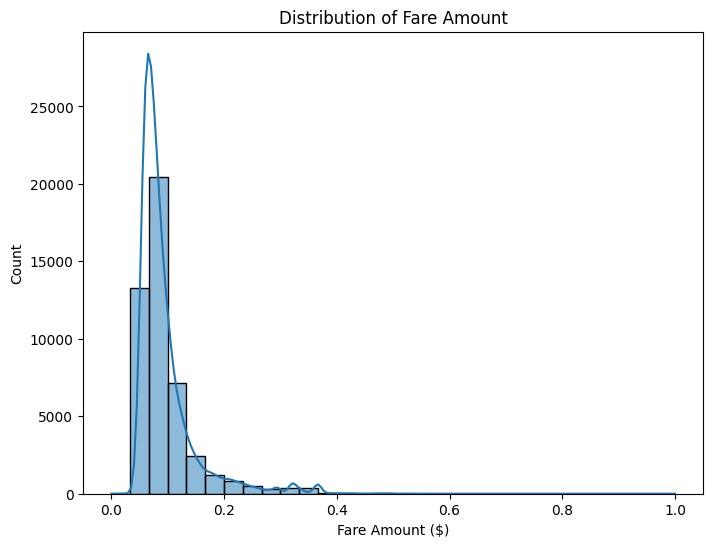

In [22]:
plt.figure(figsize=(8, 6))
sns.histplot(data['fare_amount'], bins=30, kde=True)
plt.title("Distribution of Fare Amount")
plt.xlabel("Fare Amount ($)")
plt.show()

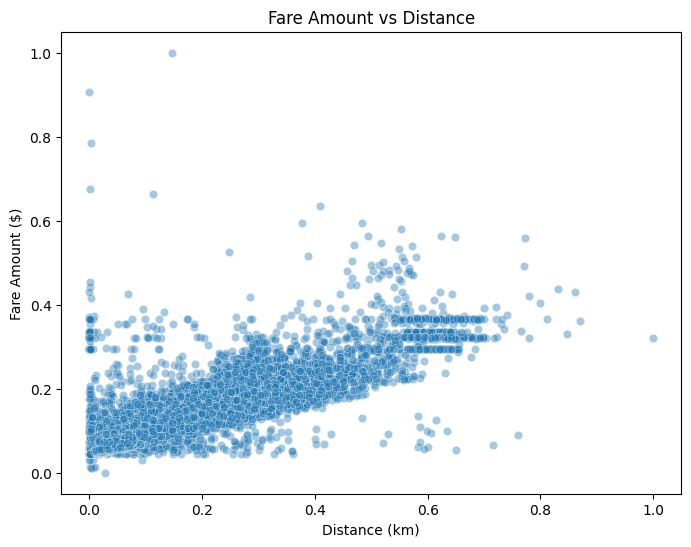

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['haversine_distance_km'], y=data['fare_amount'], alpha=0.4)
plt.title("Fare Amount vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount ($)")
plt.show()

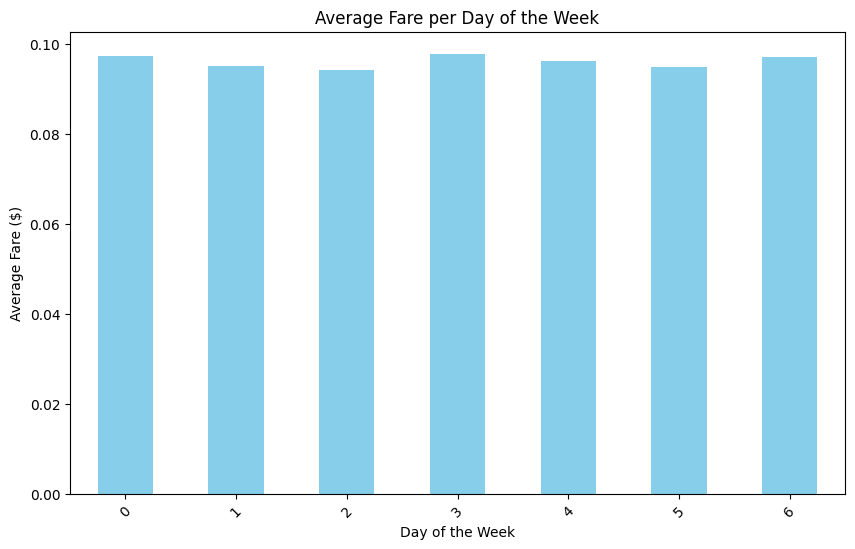

In [24]:
avg_fare_per_day = data.groupby('pickup_weekday')['fare_amount'].mean()

plt.figure(figsize=(10, 6))
avg_fare_per_day.plot(kind='bar', color='skyblue')
plt.title("Average Fare per Day of the Week")
plt.ylabel("Average Fare ($)")
plt.xlabel("Day of the Week")
plt.xticks(rotation=45)
plt.show()

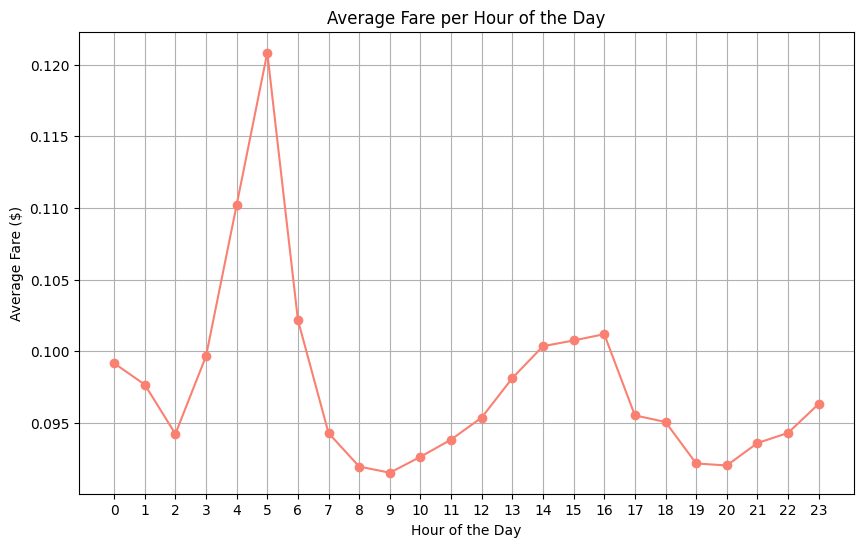

In [27]:
avg_fare_per_hour = data.groupby('pickup_hour')['fare_amount'].mean()

plt.figure(figsize=(10, 6))
avg_fare_per_hour.plot(kind='line', marker='o', color='salmon')
plt.title("Average Fare per Hour of the Day")
plt.ylabel("Average Fare ($)")
plt.xlabel("Hour of the Day")
plt.xticks(range(24))
plt.grid(True)
plt.show()

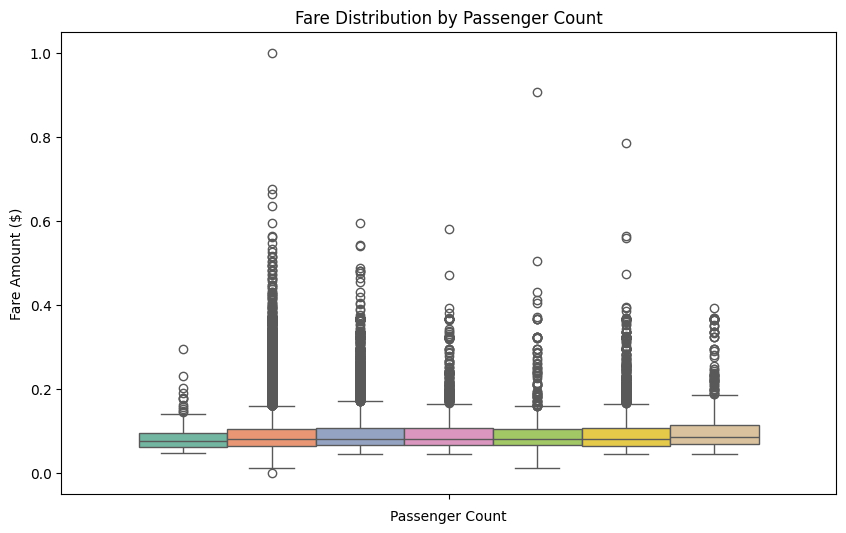

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(hue='passenger_count', y='fare_amount', data=data, palette='Set2', legend=False)
plt.title("Fare Distribution by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Fare Amount ($)")
plt.show()


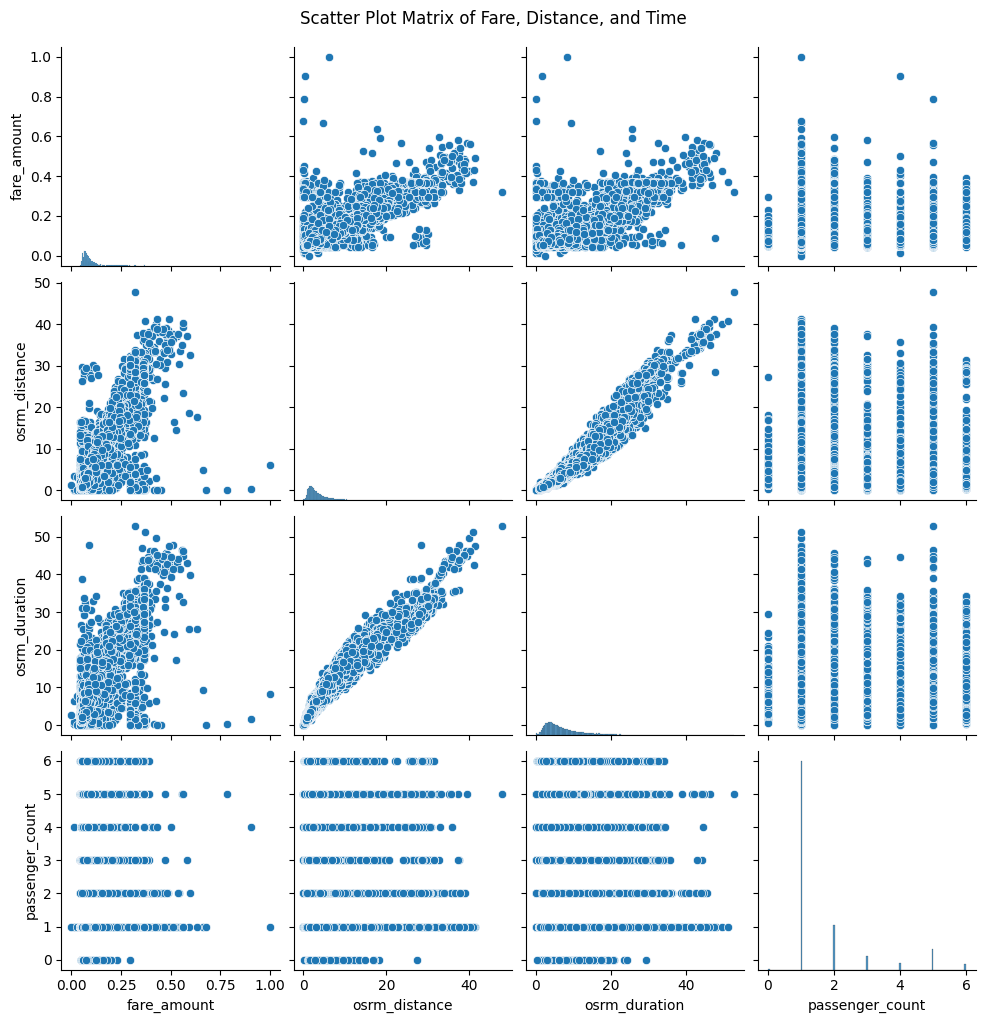

In [29]:
data_subset = data[['fare_amount', 'osrm_distance', 'osrm_duration', 'passenger_count']]

sns.pairplot(data_subset, kind='scatter', markers='o')
plt.suptitle("Scatter Plot Matrix of Fare, Distance, and Time", y=1.02)
plt.show()

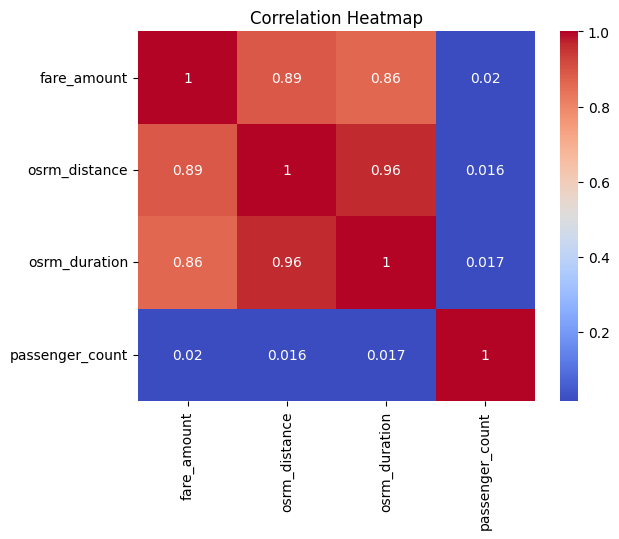

In [30]:
sns.heatmap(data_subset.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

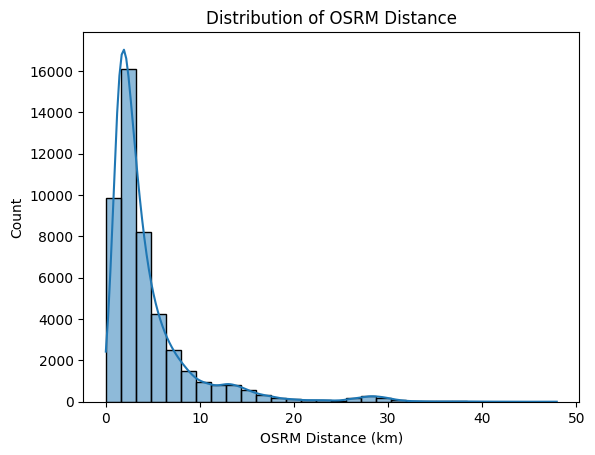

In [31]:
sns.histplot(data['osrm_distance'], bins=30, kde=True)
plt.title("Distribution of OSRM Distance")
plt.xlabel("OSRM Distance (km)")
plt.show()

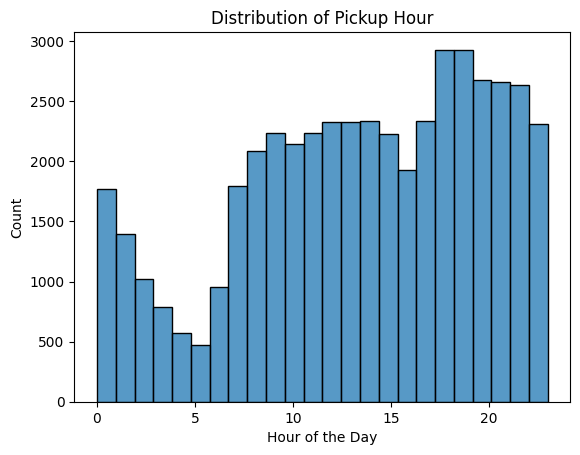

In [32]:
sns.histplot(data['pickup_hour'], bins=24)
plt.title("Distribution of Pickup Hour")    
plt.xlabel("Hour of the Day")
plt.show()

In [34]:
data.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_hour', 'pickup_weekday', 'pickup_month',
       'haversine_distance_km', 'is_night', 'is_late_night', 'is_weekend',
       'lat_diff', 'lon_diff', 'osrm_distance', 'osrm_duration',
       'near_hotspot'],
      dtype='object')

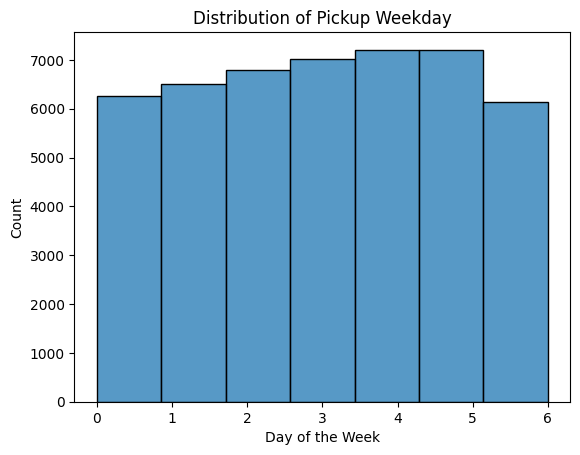

In [35]:
sns.histplot(data['pickup_weekday'], bins=7)
plt.title("Distribution of Pickup Weekday")
plt.xlabel("Day of the Week")
plt.show()

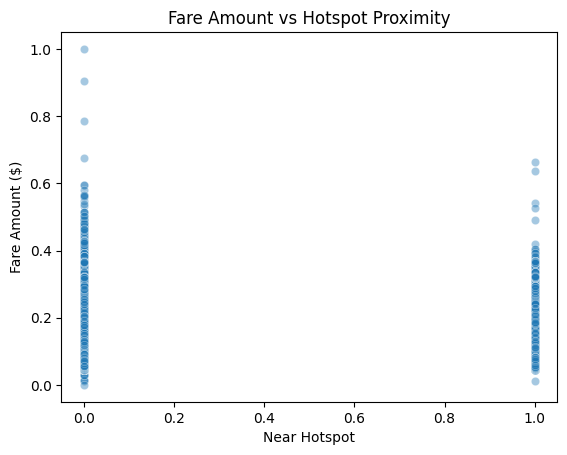

In [36]:
sns.scatterplot(x=data['near_hotspot'], y=data['fare_amount'], alpha=0.4)
plt.title("Fare Amount vs Hotspot Proximity")
plt.xlabel("Near Hotspot")
plt.ylabel("Fare Amount ($)")
plt.show()

In [37]:
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

pickup_locations = data[['pickup_latitude', 'pickup_longitude', 'fare_amount']] 

locations = pickup_locations[['pickup_latitude', 'pickup_longitude', 'fare_amount']].values.tolist()

HeatMap(locations).add_to(map_nyc)

map_nyc.save("nyc_fare_heatmap.html")

map_nyc

<Axes: xlabel='osrm_distance', ylabel='osrm_duration'>

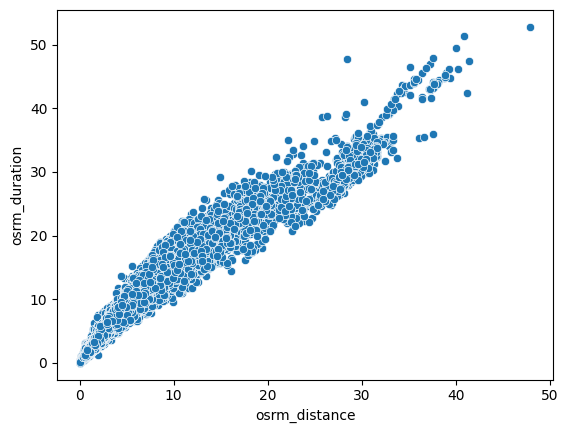

In [38]:
sns.scatterplot(x=data['osrm_distance'],y=data['osrm_duration'])

<Axes: xlabel='fare_amount', ylabel='osrm_duration'>

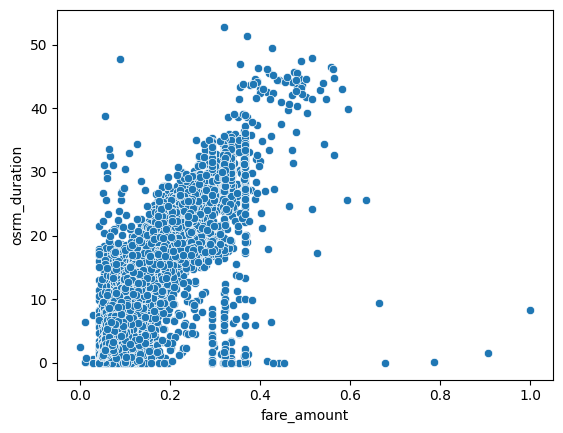

In [39]:
sns.scatterplot(x=data['fare_amount'],y=data['osrm_duration'])

In [40]:
data.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_hour', 'pickup_weekday', 'pickup_month',
       'haversine_distance_km', 'is_night', 'is_late_night', 'is_weekend',
       'lat_diff', 'lon_diff', 'osrm_distance', 'osrm_duration',
       'near_hotspot'],
      dtype='object')

In [41]:
X = data[[
    'osrm_distance',       
    'osrm_duration',       
    'pickup_hour',         
    'pickup_weekday',
    'pickup_month',
    'is_night',            
    'is_late_night',       
    'is_weekend',          
    'near_hotspot',             
]]
y = data['fare_amount']  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (32971, 9), Testing set: (14131, 9)


In [42]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)

print("Linear Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test, lr_predictions):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, lr_predictions):.2f}")
print(f"R²: {r2_score(y_test, lr_predictions):.2f}")

Linear Regression Performance:
MAE: 0.01
RMSE: 0.02
R²: 0.80


In [43]:
xgb_model = XGBRegressor(n_estimators=10, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

print("\nXGBoost Performance:")
print(f"MAE: {mean_absolute_error(y_test, xgb_predictions):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, xgb_predictions):.2f}")
print(f"R²: {r2_score(y_test, xgb_predictions):.2f}")


XGBoost Performance:
MAE: 0.02
RMSE: 0.03
R²: 0.71


In [44]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

poly_model_2 = LinearRegression()
poly_model_2.fit(X_train, y_train)

poly_model_2_predictions = poly_model_2.predict(X_test)

print("2nd Degree Polynomial Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test, poly_model_2_predictions):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, poly_model_2_predictions):.2f}")
print(f"R²: {r2_score(y_test, poly_model_2_predictions):.2f}")

2nd Degree Polynomial Regression Performance:
MAE: 0.01
RMSE: 0.02
R²: 0.80


In [45]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

poly_model_3 = LinearRegression()
poly_model_3.fit(X_train, y_train)

poly_model_3_predictions = poly_model_3.predict(X_test)

print("3rd Degree Polynomial Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test, poly_model_3_predictions):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, poly_model_3_predictions):.2f}")
print(f"R²: {r2_score(y_test, poly_model_3_predictions):.2f}")

3rd Degree Polynomial Regression Performance:
MAE: 0.01
RMSE: 0.02
R²: 0.80


In [46]:
print("Model Comparison:")
for i,j in zip([lr_predictions, poly_model_2_predictions, poly_model_3_predictions, xgb_predictions], ['Linear Regression','2nd Order Polynomial Regression', '3rd Order Polynomial Regression','XGBoost']):
    print(f"{j} -> MAE: {mean_absolute_error(y_test, i):.5f}, "
    f"RMSE: {root_mean_squared_error(y_test, i):.5f}, "
    f"R²: {r2_score(y_test, i):.5f}")

Model Comparison:
Linear Regression -> MAE: 0.01239, RMSE: 0.02418, R²: 0.79882
2nd Order Polynomial Regression -> MAE: 0.01239, RMSE: 0.02418, R²: 0.79882
3rd Order Polynomial Regression -> MAE: 0.01239, RMSE: 0.02418, R²: 0.79882
XGBoost -> MAE: 0.01735, RMSE: 0.02883, R²: 0.71399


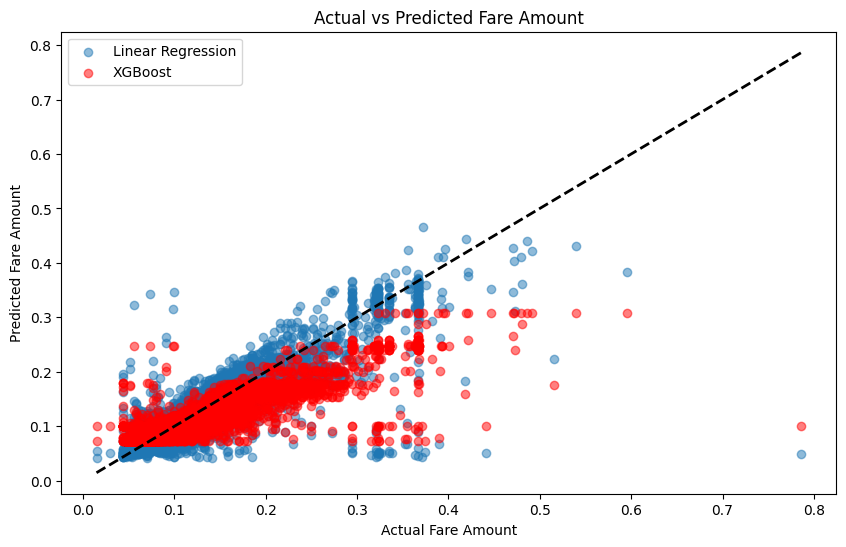

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_predictions, alpha=0.5, label="Linear Regression")
plt.scatter(y_test, xgb_predictions, alpha=0.5, label="XGBoost", color="red")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.title("Actual vs Predicted Fare Amount")
plt.legend()
plt.show()